Epoch [1/15], Loss: 1.1498, Val Loss: 0.9461
Epoch [2/15], Loss: 0.6600, Val Loss: 0.6279
Epoch [3/15], Loss: 0.2559, Val Loss: 0.3221
Epoch [4/15], Loss: 0.3449, Val Loss: 0.3580
Epoch [5/15], Loss: 0.1519, Val Loss: 0.1948
Epoch [6/15], Loss: 0.1522, Val Loss: 0.1466
Epoch [7/15], Loss: 0.1248, Val Loss: 0.1286
Epoch [8/15], Loss: 0.1225, Val Loss: 0.1106
Epoch [9/15], Loss: 0.0865, Val Loss: 0.0945
Epoch [10/15], Loss: 0.0791, Val Loss: 0.0829
Epoch [11/15], Loss: 0.0706, Val Loss: 0.0751
Epoch [12/15], Loss: 0.0537, Val Loss: 0.0679
Epoch [13/15], Loss: 0.0442, Val Loss: 0.0623
Epoch [14/15], Loss: 0.0549, Val Loss: 0.0575
Epoch [15/15], Loss: 0.0438, Val Loss: 0.0517


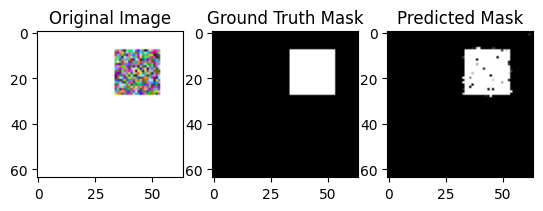

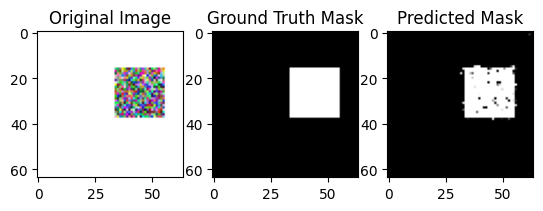

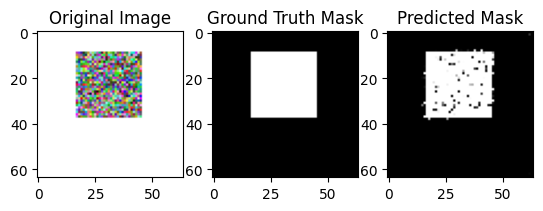

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Synthetic dataset class
class SyntheticDataset(Dataset):
    def __init__(self, num_samples=100, image_size=(64, 64)):
        self.num_samples = num_samples
        self.image_size = image_size
        self.images, self.masks = self.generate_dataset()

    def generate_dataset(self):
        images = []
        masks = []
        for _ in range(self.num_samples):
            image = np.ones((3, *self.image_size), dtype=np.uint8) * 255  # White background
            mask = np.zeros(self.image_size, dtype=np.uint8)

            # Add a random shape
            shape_size = np.random.randint(10, 30)
            x, y = np.random.randint(5, self.image_size[0] - shape_size - 5, size=2)
            image[:, x:x + shape_size, y:y + shape_size] = np.random.randint(0, 256, size=(3, shape_size, shape_size))
            mask[x:x + shape_size, y:y + shape_size] = 1

            images.append(image)
            masks.append(mask)

        return torch.tensor(images, dtype=torch.float32), torch.tensor(masks, dtype=torch.float32)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.images[idx], self.masks[idx]

# Define a simple CNN model
class SimpleSegmentationModel(nn.Module):
    def __init__(self):
        super(SimpleSegmentationModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        return torch.sigmoid(x)

# Instantiate the model, dataset, and dataloaders
model = SimpleSegmentationModel()
dataset = SyntheticDataset()
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))  # Binary cross-entropy loss
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_dataloader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets.unsqueeze(1)).item()

    average_val_loss = val_loss / len(val_dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {average_val_loss:.4f}')

# Test the model on a few validation images
model.eval()
with torch.no_grad():
    for i in range(3):  # Test on three validation images
        val_image, val_mask = val_dataset[i]
        val_image = val_image.unsqueeze(0)
        predicted_mask = model(val_image)

        # Plot the results
        plt.subplot(1, 3, 1)
        plt.title('Original Image')
        plt.imshow(val_image.squeeze().permute(1, 2, 0).numpy().astype(np.uint8))
        plt.subplot(1, 3, 2)
        plt.title('Ground Truth Mask')
        plt.imshow(val_mask.numpy(), cmap='gray')
        plt.subplot(1, 3, 3)
        plt.title('Predicted Mask')
        plt.imshow(predicted_mask.squeeze().numpy(), cmap='gray')
        plt.show()
